In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    make_scorer,

)

from sklearn.feature_selection import SelectKBest, chi2


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/healthcare_data_cleaned.csv')

In [3]:
df.head()

,ptid,persistency_flag,gender,race,ethnicity,region,age_bucket,ntm_speciality,ntm_specialist_flag,ntm_speciality_bucket,...,risk_family_history_of_osteoporosis,risk_low_calcium_intake,risk_vitamin_d_insufficiency,risk_poor_health_frailty,risk_excessive_thinness,risk_hysterectomy_oophorectomy,risk_estrogen_deficiency,risk_immobilization,risk_recurring_falls,count_of_risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Other,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1


#Data preparation for modeling

In [4]:
df.drop(["ptid"], axis=1, inplace=True)

In [5]:
#encoding persistency flag
df["persistency_flag"] = df["persistency_flag"].apply(lambda x: 1 if x == "Persistent" else 0)

In [6]:
X = df.drop(["persistency_flag"], axis=1)
Y = df["persistency_flag"]

X = pd.get_dummies(X, drop_first=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1,stratify=Y)

#Selecting best features

In [8]:
selector = SelectKBest(chi2, k='all')
X_train_new = selector.fit_transform(X_train, y_train)

In [9]:
p_values = selector.pvalues_

p_values_df = pd.DataFrame({
    'Feature': X_train.columns,
    'P-Value': p_values
})

In [10]:
threshold = 0.05
selected_features = p_values_df[p_values_df['P-Value'] < threshold]

In [11]:
selected_feature_names = selected_features['Feature'].values

In [12]:
print("Selected Features based on low p-values:")
print(selected_feature_names)

Selected Features based on low p-values:
['dexa_freq_during_rx' 'count_of_risks' 'region_West'
 'ntm_speciality_ENDOCRINOLOGY' 'ntm_speciality_GENERAL PRACTITIONER'
 'ntm_speciality_ONCOLOGY' 'ntm_speciality_PATHOLOGY'
 'ntm_speciality_PHYSICAL MEDICINE AND REHABILITATION'
 'ntm_specialist_flag_Specialist'
 'ntm_speciality_bucket_OB/GYN/Others/PCP/Unknown'
 'gluco_record_during_rx_Y' 'dexa_during_rx_Y' 'frag_frac_during_rx_Y'
 'adherent_flag_Non-Adherent' 'idn_indicator_Y'
 'injectable_experience_during_rx_Y'
 'comorb_encounter_for_screening_for_malignant_neoplasms_Y'
 'comorb_encounter_for_immunization_Y'
 'comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx_Y'
 'comorb_vitamin_d_deficiency_Y'
 'comorb_other_joint_disorder_not_elsewhere_classified_Y'
 'comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx_Y'
 'comorb_long_term_current_drug_therapy_Y' 'comorb_dorsalgia_Y'
 'comorb_personal_history_of_other_diseases_and_conditions_Y'
 'comorb_other_disorders_of_

In [13]:
X_train_selected = X_train[selected_feature_names]

X_test_selected = X_test[selected_feature_names]

In [14]:
X_train_selected = sm.add_constant(X_train_selected)
X_test_selected = sm.add_constant(X_test_selected)

In [15]:
X_train_selected = X_train_selected.astype("float")
X_test_selected = X_test_selected.astype("float")

In [16]:
logit = sm.Logit(y_train, X_train_selected)

lg = logit.fit(disp=False)

print(lg.summary())

                           Logit Regression Results                           
Dep. Variable:       persistency_flag   No. Observations:                 2396
Model:                          Logit   Df Residuals:                     2350
Method:                           MLE   Df Model:                           45
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.3936
Time:                        13:09:50   Log-Likelihood:                -962.25
converged:                      False   LL-Null:                       -1586.9
Covariance Type:            nonrobust   LLR p-value:                2.943e-232
                                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                   -3.7372      0.456    

##Model performance evaluation

In [17]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification_statsmodels(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred_temp = model.predict(predictors) > threshold
    # rounding off the above values to get classes
    pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [18]:
# defining a function to plot the confusion_matrix of a classification model


def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    y_pred = model.predict(predictors) > threshold
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

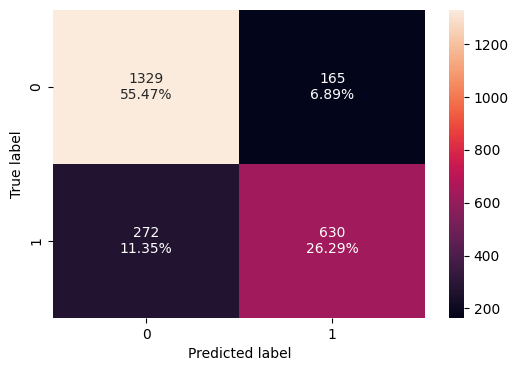

In [19]:
confusion_matrix_statsmodels(lg, X_train_selected, y_train)

In [20]:
print("Training performance:")
model_performance_classification_statsmodels(lg, X_train_selected, y_train)

Training performance:


,Accuracy,Recall,Precision,F1
0,0.817613,0.698448,0.792453,0.742487


In [21]:
print("Testing performance:")
model_performance_classification_statsmodels(lg, X_test_selected, y_test)

Testing performance:


,Accuracy,Recall,Precision,F1
0,0.79572,0.635659,0.780952,0.700855


#AUC-ROC curve

on training set

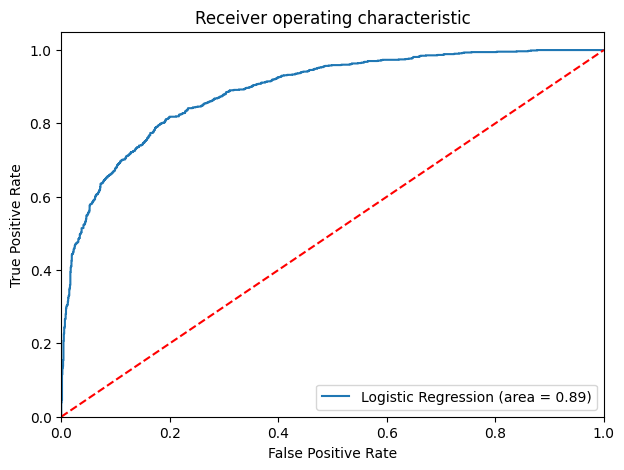

In [22]:
logit_roc_auc_train = roc_auc_score(y_train, lg.predict(X_train_selected))
fpr, tpr, thresholds = roc_curve(y_train, lg.predict(X_train_selected))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

on test set

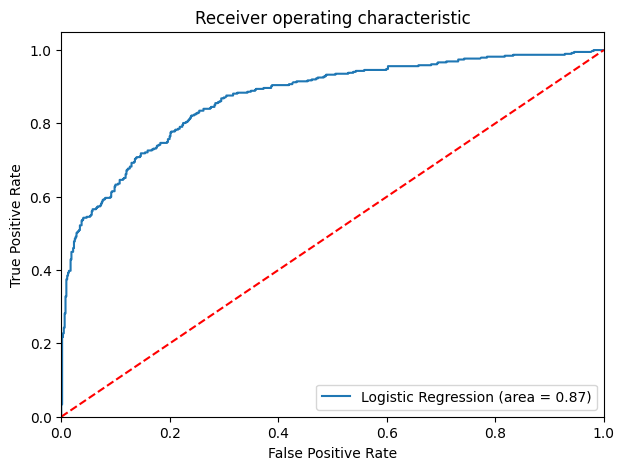

In [23]:
logit_roc_auc_test = roc_auc_score(y_test, lg.predict(X_test_selected))
fpr, tpr, thresholds = roc_curve(y_test, lg.predict(X_test_selected))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [24]:
auc_train = roc_auc_score(y_train, lg.predict(X_train_selected))
print("AUC train: %.2f" % auc_train)

AUC train: 0.89


In [25]:
auc_test = roc_auc_score(y_test, lg.predict(X_test_selected))
print("AUC test: %.2f" % auc_test)

AUC test: 0.87


###Optimal threshold

In [26]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = roc_curve(y_test, lg.predict(X_test_selected))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.2813802996029271


###Checking model performance with the optimal threshold

In [27]:
log_reg_model_train_perf_threshold_auc_roc = model_performance_classification_statsmodels(
    lg, X_train_selected, y_train, threshold=optimal_threshold_auc_roc
)
print("Training performance:")
log_reg_model_train_perf_threshold_auc_roc

Training performance:


,Accuracy,Recall,Precision,F1
0,0.787145,0.843681,0.673451,0.749016


In [28]:
log_reg_model_test_perf_threshold_auc_roc = model_performance_classification_statsmodels(
    lg, X_test_selected, y_test, threshold=optimal_threshold_auc_roc
)
print("Testing performance:")
log_reg_model_test_perf_threshold_auc_roc

Testing performance:


,Accuracy,Recall,Precision,F1
0,0.782101,0.819121,0.673036,0.738928


###Precision-Recall Curve

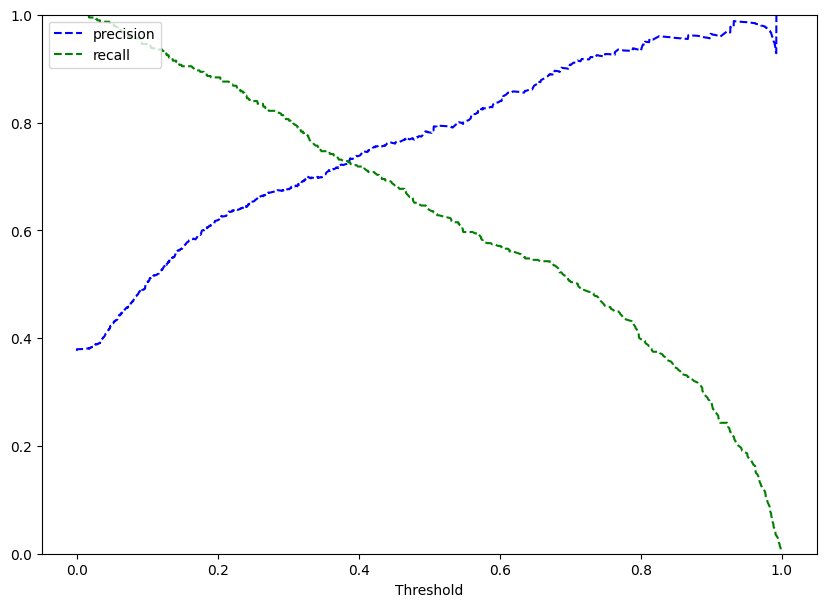

In [29]:
#Plotting the precision-recall curve
y_scores = lg.predict(X_test_selected)
prec, rec, thres = precision_recall_curve(y_test, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, thres)
plt.show()

In [30]:
#locating the optimal threshold
pre_recall_thres = pd.DataFrame({"Threshold" : thres,
                                 "Precision" : prec[:-1],
                                 "Recall" : rec[:-1]})

match_index = np.argwhere(prec[:-1] == rec[:-1])

match_index

array([[625]])

In [31]:
pre_recall_thres.loc[625]

,625
Threshold,0.385957
Precision,0.726098
Recall,0.726098


In [32]:
optimal_threshold_pre_rec = 0.385957

###Checking model performance with the precision-recall threshold

In [33]:
log_reg_model_train_perf_threshold_pre_rec = model_performance_classification_statsmodels(
    lg, X_train_selected, y_train, threshold= optimal_threshold_pre_rec)

print("Training performance:")
log_reg_model_train_perf_threshold_pre_rec

Training performance:


,Accuracy,Recall,Precision,F1
0,0.8101,0.762749,0.740581,0.751502


In [34]:
#Testing performance
log_reg_model_test_perf_threshold_pre_rec = model_performance_classification_statsmodels(
    lg, X_test_selected, y_test, threshold= optimal_threshold_pre_rec)

print("Testing performance:")
log_reg_model_test_perf_threshold_pre_rec

Testing performance:


,Accuracy,Recall,Precision,F1
0,0.794747,0.726098,0.727979,0.727038


#Coefficient interpretation

In [35]:
# converting coefficients to odds
odds = np.exp(lg.params)

# finding the percentage change
perc_change_odds = (np.exp(lg.params) - 1) * 100

# removing limit from number of columns to display
pd.set_option("display.max_columns", None)

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=X_train_selected.columns).T

,const,dexa_freq_during_rx,count_of_risks,region_West,ntm_speciality_ENDOCRINOLOGY,ntm_speciality_GENERAL PRACTITIONER,ntm_speciality_ONCOLOGY,ntm_speciality_PATHOLOGY,ntm_speciality_PHYSICAL MEDICINE AND REHABILITATION,ntm_specialist_flag_Specialist,ntm_speciality_bucket_OB/GYN/Others/PCP/Unknown,gluco_record_during_rx_Y,dexa_during_rx_Y,frag_frac_during_rx_Y,adherent_flag_Non-Adherent,idn_indicator_Y,injectable_experience_during_rx_Y,comorb_encounter_for_screening_for_malignant_neoplasms_Y,comorb_encounter_for_immunization_Y,"comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx_Y",comorb_vitamin_d_deficiency_Y,comorb_other_joint_disorder_not_elsewhere_classified_Y,comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx_Y,comorb_long_term_current_drug_therapy_Y,comorb_dorsalgia_Y,comorb_personal_history_of_other_diseases_and_conditions_Y,comorb_other_disorders_of_bone_density_and_structure_Y,comorb_disorders_of_lipoprotein_metabolism_and_other_lipidemias_Y,comorb_osteoporosis_without_current_pathological_fracture_Y,comorb_personal_history_of_malignant_neoplasm_Y,comorb_gastro_esophageal_reflux_disease_Y,concom_cholesterol_and_triglyceride_regulating_preparations_Y,concom_narcotics_Y,concom_systemic_corticosteroids_plain_Y,concom_anti_depressants_and_mood_stabilisers_Y,concom_fluoroquinolones_Y,concom_cephalosporins_Y,concom_macrolides_and_similar_types_Y,concom_broad_spectrum_penicillins_Y,concom_anaesthetics_general_Y,concom_viral_vaccines_Y,risk_untreated_chronic_hypogonadism_Y,risk_smoking_tobacco_Y,risk_vitamin_d_insufficiency_Y,risk_poor_health_frailty_Y,risk_immobilization_Y
Odds,0.023821,1.026496,0.748823,1.212212,1.780455,0.781582,2.925788,3.787642,2.228084e-08,1.202715,1.244230,0.953548,4.724072,1.11279,1.401133,1.353623,1.568316,1.858391,1.517685,1.955453,2.071679,1.562235,1.225937,2.326305,1.573077,1.341869,2.258539,1.007706,0.689383,0.917143,1.231523,0.981274,0.775905,1.658901,1.052204,1.358125,1.081461,1.391680,1.809078,1.302543,2.273769,3.556207,1.337083,0.922894,0.595096,7.167682e-21
Change_odd%,-97.617895,2.649565,-25.117703,21.221161,78.045516,-21.841770,192.578817,278.764238,-1.000000e+02,20.271535,24.422993,-4.645173,372.407180,11.27902,40.113324,35.362307,56.831579,85.839133,51.768549,95.545315,107.167934,56.223473,22.593687,132.630459,57.307744,34.186892,125.853945,0.770576,-31.061669,-8.285652,23.152325,-1.872616,-22.409491,65.890075,5.220410,35.812534,8.146087,39.168037,80.907838,30.254267,127.376867,255.620677,33.708320,-7.710576,-40.490447,-1.000000e+02
